In [1]:
import my_plotting
import markers
import importlib
import utils
import covax_constants
import CovidVAX_specific_utils
import GeneModules

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np

import warnings
warnings.simplefilter("ignore")

from collections import Counter
import scanpy as sc

In [2]:
adata = sc.read_h5ad(f'Monocyte CD14-2.h5ad')

In [3]:
adata.obs['subsets'] = pd.Categorical(adata.obs['new_subset_annotations_2'].map({
    'Monocyte CD14': 'CD14 ISG Low',
    'Monocyte CD14 ISG 1': 'CD14 ISG High',
    'Monocyte CD14 ISG 2': 'CD14 ISG High',
    'Monocyte CD14 ISG (Low)': 'CD14 ISG Dim',
    'Monocyte CD14 ISG Inflamm.': 'CD14 ISG High',
}),  categories=['CD14 ISG Low', 'CD14 ISG Dim', 'CD14 ISG High'])

In [4]:
adata = adata[adata.obs.Vaccine!='J&J', :].copy()

In [5]:
adata.obs['subset_vax'] = utils.make_combined_column(adata, ['subsets', 'Vaccine'])
adata.obs['subset_vax'] = pd.Categorical(adata.obs['subset_vax'], categories=['CD14 ISG High Moderna', 'CD14 ISG High Pfizer',
                                            'CD14 ISG Dim Moderna', 'CD14 ISG Dim Pfizer',
                                                 'CD14 ISG Low Moderna', 'CD14 ISG Low Pfizer']
                                          )

In [6]:
df = pd.read_csv('CD14 Monocyte subsets DEG.csv', index_col=0, header = [0, 1])

In [7]:
df

CD14 ISG High vs CD14 ISG Dim                                  \
                           statistic    pvalue foldchange pvalue_adj   
ISG15                      -1.905427  0.083183   0.798245   0.137915   
GNB1                       -0.328351  0.748812   0.984142   0.812196   
KCNAB2                     -2.983685  0.012437   0.852183   0.030278   
RERE                       -1.915165  0.081821   0.926372   0.136344   
ENO1                        3.585845  0.004275   1.294293   0.013013   
...                              ...       ...        ...        ...   
STAG2                      -0.072263  0.943690   0.996557   0.964104   
RBMX                       -0.102781  0.919987   0.995614   0.946321   
IDS                        -2.177791  0.052065   0.826908   0.092641   
FLNA                        0.006551  0.994890   1.000257   0.999329   
UTY                        -1.629960  0.131384   0.901101   0.197276   

       CD14 ISG High vs CD14 ISG Low                                  \
                           statistic    pvalue foldchange pvalue_adj   
ISG15                       6.803531  0.000029   4.728050   0.000149   
GNB1                       -2.178528  0.051998   0.947395   0.075787   
KCNAB2                     -6.253531  0.000062   0.725086   0.000259   
RERE                        0.569060  0.580749   1.026853   0.627027   
ENO1                        2.132009  0.056383   1.090038   0.081327   
...                              ...       ...        ...        ...   
STAG2                      -0.584887  0.570426   0.982316   0.617090   
RBMX                        1.512217  0.158664   1.051934   0.201283   
IDS                        -5.021682  0.000389   0.773747   0.001070   
FLNA                       -1.838924  0.093053   0.940317   0.126902   
UTY                        -1.530312  0.154176   0.902244   0.197101   

       CD14 ISG Dim vs CD14 ISG High            ...  \
                           statistic    pvalue  ...   
ISG15                       1.905427  0.083183  ...   
GNB1                        0.328351  0.748812  ...   
KCNAB2                      2.983685  0.012437  ...   
RERE                        1.915165  0.081821  ...   
ENO1                       -3.585845  0.004275  ...   
...                              ...       ...  ...   
STAG2                       0.072263  0.943690  ...   
RBMX                        0.102781  0.919987  ...   
IDS                         2.177791  0.052065  ...   
FLNA                       -0.006551  0.994890  ...   
UTY                         1.629960  0.131384  ...   

       CD14 ISG Dim vs CD14 ISG Low            CD14 ISG Low vs CD14 ISG High  \
                         foldchange pvalue_adj                     statistic   
ISG15                      5.923058   0.000004                     -6.803531   
GNB1                       0.962661   0.578046                      2.178528   
KCNAB2                     0.850857   0.012279                      6.253531   
RERE                       1.108467   0.009965                     -0.569060   
ENO1                       0.842188   0.011309                     -2.132009   
...                             ...        ...                           ...   
STAG2                      0.985709   0.845013                      0.584887   
RBMX                       1.056568   0.437160                     -1.512217   
IDS                        0.935711   0.539541                      5.021682   
FLNA                       0.940075   0.181361                      1.838924   
UTY                        1.001269   0.990755                      1.530312   

                                       CD14 ISG Low vs CD14 ISG Dim  \
          pvalue foldchange pvalue_adj                    statistic   
ISG15   0.000029   0.211504   0.000149                   -12.690069   
GNB1    0.051998   1.055526   0.075787                     0.926286   
KCNAB2  0.000062   1.379147   0.000259                     4.258706   
RERE    0.580749   0.

In [72]:
# To shorten the list, I will play with the thresholds

sortby = 'pvalue_adj'

# high : high vs low AND high vs dim
high = df[
    (df[('CD14 ISG High vs CD14 ISG Dim', 'pvalue_adj')] < 0.0001) & (df[('CD14 ISG High vs CD14 ISG Dim', 'foldchange')] > 2) &
    (df[('CD14 ISG High vs CD14 ISG Low', 'pvalue_adj')] < 0.0001) & (df[('CD14 ISG High vs CD14 ISG Low', 'foldchange')] > 2)
].sort_values(by = ('CD14 ISG High vs CD14 ISG Dim', sortby))

# dim (mid) : dim vs high AND dim vs low
dim = df[
    (df[('CD14 ISG Dim vs CD14 ISG High', 'pvalue_adj')] < 0.001) & (df[('CD14 ISG Dim vs CD14 ISG High', 'foldchange')] > 1.4) &
    (df[('CD14 ISG Dim vs CD14 ISG Low', 'pvalue_adj')] < 0.001) & (df[('CD14 ISG Dim vs CD14 ISG Low', 'foldchange')] > 1.4)
].sort_values(by = ('CD14 ISG Dim vs CD14 ISG High', sortby))


# high and dim high == dim AND high > low AND mid > low
high_and_dim = df[
    (df[('CD14 ISG High vs CD14 ISG Dim', 'pvalue_adj')] > 0.1) &
    (df[('CD14 ISG High vs CD14 ISG Low', 'pvalue_adj')] < 0.0001) & (df[('CD14 ISG High vs CD14 ISG Low', 'foldchange')] > 2) &
    (df[('CD14 ISG Dim vs CD14 ISG Low', 'pvalue_adj')] < 0.0001) & (df[('CD14 ISG Dim vs CD14 ISG Low', 'foldchange')] > 2)
].sort_values(by = ('CD14 ISG Dim vs CD14 ISG Low', sortby), ascending=False)


# dim and low; dim == low AND dim > high AND low > high
dim_and_low = df[
    (df[('CD14 ISG Dim vs CD14 ISG Low', 'pvalue_adj')] > 0.1) &
    (df[('CD14 ISG Dim vs CD14 ISG High', 'pvalue_adj')] < 0.001) & (df[('CD14 ISG Dim vs CD14 ISG High', 'foldchange')] > 2) &
    (df[('CD14 ISG Low vs CD14 ISG High', 'pvalue_adj')] < 0.001) & (df[('CD14 ISG Low vs CD14 ISG High', 'foldchange')] > 2)
].sort_values(by = ('CD14 ISG Low vs CD14 ISG High', sortby))


In [73]:
picked_genes = {
    'High Specific' : sorted(high.index.tolist()), 
    'High and Dim' :  sorted(high_and_dim.index.tolist()),
    'Dim Specific' : sorted(dim.index.tolist()),
    'Dim and Low' : sorted(dim_and_low.index.tolist()),
    # 'Low Specific': low.index.tolist(),
    # 'High and Low': high_and_low.index.tolist(),
}

In [45]:
print('{')
for key, vals in picked_genes.items():
    print(f"\t'{key}' : ", repr(vals), ',', sep='') 
print('}')

{
	'High Specific' : ['APOL3', 'CAMK2D', 'DYSF', 'FARP2', 'FRMD3', 'GBP1', 'GBP2', 'GBP5', 'LIMK2', 'MYOF', 'NCF1', 'PSMB9', 'SAMD4A', 'SECTM1', 'WARS'],
	'High and Dim' : ['ADAR', 'DDX60', 'EPSTI1', 'IFI16', 'IFIH1', 'PARP14', 'PARP9', 'RNF213', 'SMCHD1', 'SP110', 'STAT2', 'TRIM22', 'ZC3HAV1'],
	'Dim Specific' : ['COA1', 'DDX58', 'EIF2AK2', 'IFI44', 'IFI44L', 'ITSN1', 'KIAA1958', 'MX1', 'MX2', 'TENT5A', 'ZCCHC2'],
	'Dim and Low' : ['F13A1', 'FAM13A', 'LDLRAD4', 'NLRP12', 'SSBP2', 'TIAM1', 'TMEM71'],
}


In [78]:
# Short list
picked_genes = {
	'High Specific' : ['APOL3', 'CAMK2D', 'DYSF', 'FARP2', 'FRMD3', 'GBP1', 'GBP2', 'GBP5', 'LIMK2', 'MYOF', 'NCF1', 'PSMB9', 'SAMD4A', 'SECTM1', 'WARS'],
	'High and Dim' : ['ADAR', 'DDX60', 'EPSTI1', 'IFI16', 'IFIH1', 'PARP14', 'PARP9', 'RNF213', 'SMCHD1', 'SP110', 'STAT2', 'TRIM22', 'ZC3HAV1'],
	'Dim Specific' : ['COA1', 'DDX58', 'EIF2AK2', 'IFI44', 'IFI44L', 'ITSN1', 'KIAA1958', 'MX1', 'MX2', 'TENT5A', 'ZCCHC2'],
	'Dim and Low' : ['F13A1', 'LDLRAD4', 'NLRP12', 'SSBP2', 'TIAM1', 'TMEM71'], # FAM13A
}
# FAM13A is not in Bali's data

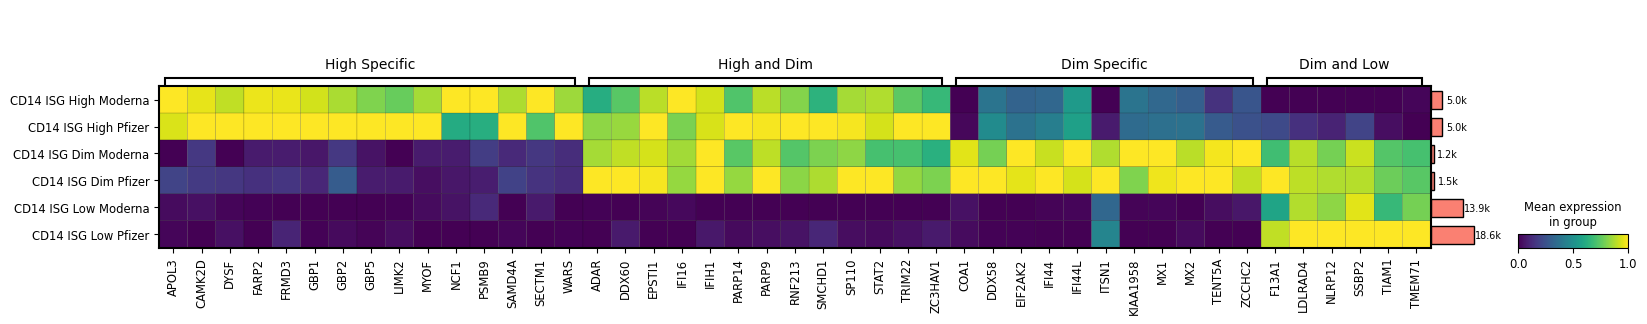

In [79]:
mp = sc.pl.matrixplot(adata, 
              picked_genes,
              groupby = 'subset_vax', 
              standard_scale = 'var',
              var_group_rotation = 0,
              return_fig=True
             )

mp.add_totals().style(edge_color='black').show()
fig = mp.fig
# my_plotting.savefig_png_eps(fig, 'cd14_subsets_isg_matrixplot_short', make_folder=True, use_timestamp=False)

In [81]:
for name, l in picked_genes.items():
    print(name, ':',  *l)

High Specific : APOL3 CAMK2D DYSF FARP2 FRMD3 GBP1 GBP2 GBP5 LIMK2 MYOF NCF1 PSMB9 SAMD4A SECTM1 WARS
High and Dim : ADAR DDX60 EPSTI1 IFI16 IFIH1 PARP14 PARP9 RNF213 SMCHD1 SP110 STAT2 TRIM22 ZC3HAV1
Dim Specific : COA1 DDX58 EIF2AK2 IFI44 IFI44L ITSN1 KIAA1958 MX1 MX2 TENT5A ZCCHC2
Dim and Low : F13A1 LDLRAD4 NLRP12 SSBP2 TIAM1 TMEM71


In [82]:
total = 0
for name, l in picked_genes.items():
    total+=len(l)
    print(name, ':',  len(l))
print(total)

High Specific : 15
High and Dim : 13
Dim Specific : 11
Dim and Low : 6
45
